# Setup

## Import Libraries

In [6]:
from datasets import *
from train import *
from torchvision import datasets, transforms, models
from matplotlib.pyplot import figure

## Load Models

In [110]:
model = models.mobilenet_v3_large(weights='DEFAULT').to('cuda')
model64 = models.mobilenet_v3_large()
model64.load_state_dict(torch.load("best_modelsv3/best_batch_i1081020.pth")['model_state_dict'])
model64.to('cuda')
model.eval()
model64.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Load Validation Sets

### Clean Validation Sets

In [109]:
clean_val_loader = load_imagenet(128,1234,False)
clean_val_loader64 = load_imagenet64(128,1234,False)

### Corrupted Validation Sets

In [4]:
corruptions = ['gaussian_noise','impulse_noise','shot_noise','defocus_blur','glass_blur','motion_blur','zoom_blur','snow','frost','fog','brightness','contrast','elastic_transform','jpeg_compression','pixelate']

corr_val_loaders = []
corr_val_loaders64 = []
for corr in corruptions:
    corr_val_loaders.append(load_imagenetc_val(128,1234,corr,severity=1))
    corr_val_loaders64.append(load_imagenetc64_val(128,1234,corr,severity=1))

# Baseline Accuracies

## test clean validation sets

In [5]:
acc_clean = validate(model,clean_val_loader,'cuda')
acc64_clean = validate(model64,clean_val_loader64,'cuda')

100%|██████████| 391/391 [00:18<00:00, 20.64it/s]


## test corrupted validation sets

In [7]:
acc_corr = []
acc_corr64 = []

for i,corr_set in enumerate(corr_val_loaders):
    acc_corr.append(validate(model,corr_val_loaders[i],'cuda')[0])
    acc_corr64.append(validate(model64,corr_val_loaders64[i],'cuda')[0])

100%|██████████| 391/391 [00:04<00:00, 81.21it/s]


## save results to csv

In [8]:
import pandas as pd
df = pd.DataFrame(columns=corruptions)
df.loc[0] = acc_corr
df.loc[1] = acc_corr64
df.insert(0, "Model", ['224x224', '64x64'])
df.insert(1,'Clean Acc.',[acc_clean,acc64_clean])
df.insert(2,'Avg Corr. Acc.',[sum(acc_corr)/len(acc_corr),sum(acc_corr64)/len(acc_corr64)])
df.to_csv("accuracy results1.csv")

# Get confidence Scores

## clean confidence scores

### function to get confidence bins and distribution

In [111]:
# pass in validation set and model
def get_conf_cal(data_loader, model):
    # store the confidence and prediction result for each sample
    confidences = torch.zeros(len(data_loader.dataset))
    accuracies = torch.zeros(len(data_loader.dataset))

    # get the confidence and predictions result for each sample
    idx = 0
    with torch.no_grad():
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            # save the next batch of results based on start and end idxs
            start = idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            confidences[start:end] = conf
            accuracies[start:end] = acc
            idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/len(data_loader.dataset)

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1

    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

get the confidence scores for both 224 and 64

In [112]:
accs_cal, confs_cal, confs_hist, total_avg_conf, total_acc = get_conf_cal(clean_val_loader,model)
accs64_cal, confs64_cal, confs_hist64, total_avg_conf64, total_acc64 = get_conf_cal(clean_val_loader64,model64)

100%|██████████| 391/391 [00:13<00:00, 28.83it/s]


conf hist for 224

(-2.5, 47.5)

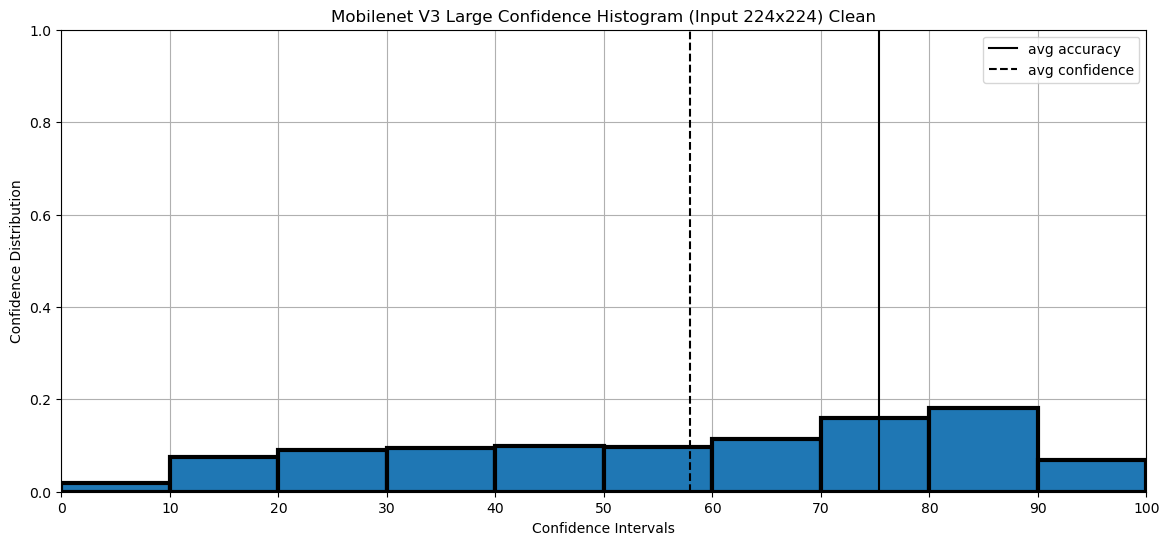

In [117]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 224

[tensor(0.0550), tensor(0.1247), tensor(0.1759), tensor(0.2160), tensor(0.2206), tensor(0.2373), tensor(0.2229), tensor(0.1905), tensor(0.1280), tensor(0.0457)]
[tensor(0.0769), tensor(0.1528), tensor(0.2508), tensor(0.3508), tensor(0.4500), tensor(0.5506), tensor(0.6525), tensor(0.7538), tensor(0.8466), tensor(0.9344)]


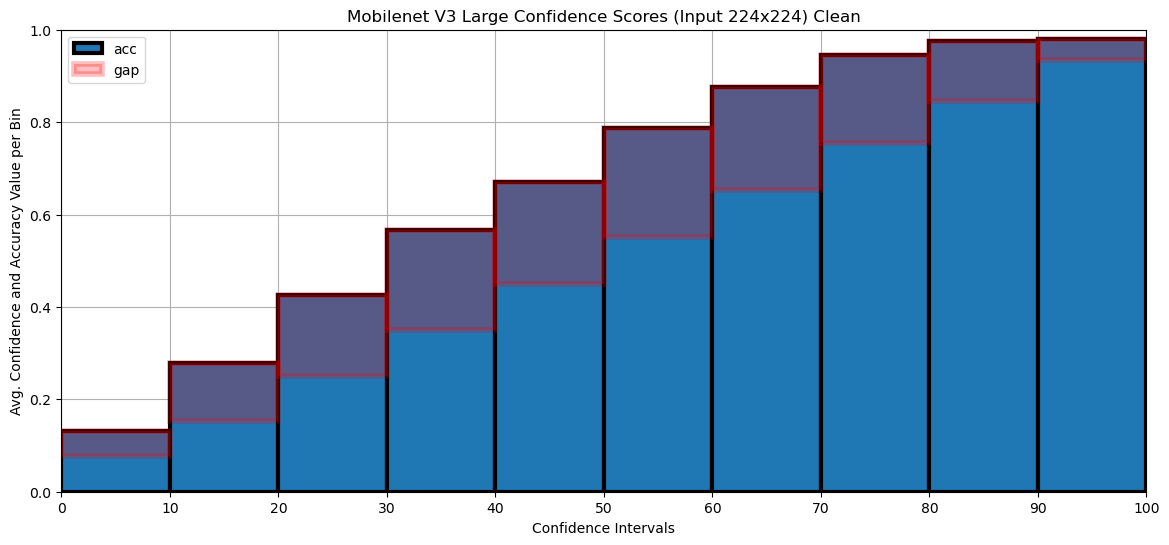

In [118]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs_cal):
    if c > accs_cal[i]:
        bot.append(accs_cal[i])
        top.append(c-accs_cal[i])
    else:
        bot.append(c)
        top.append(accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [155]:
print("ECE:",sum([abs(accs_cal[i] - confs_cal[i])*confs_hist[i] for i in range(len(confs_cal))]))

ECE: tensor(0.1738)


conf hist for 64

(-2.5, 47.5)

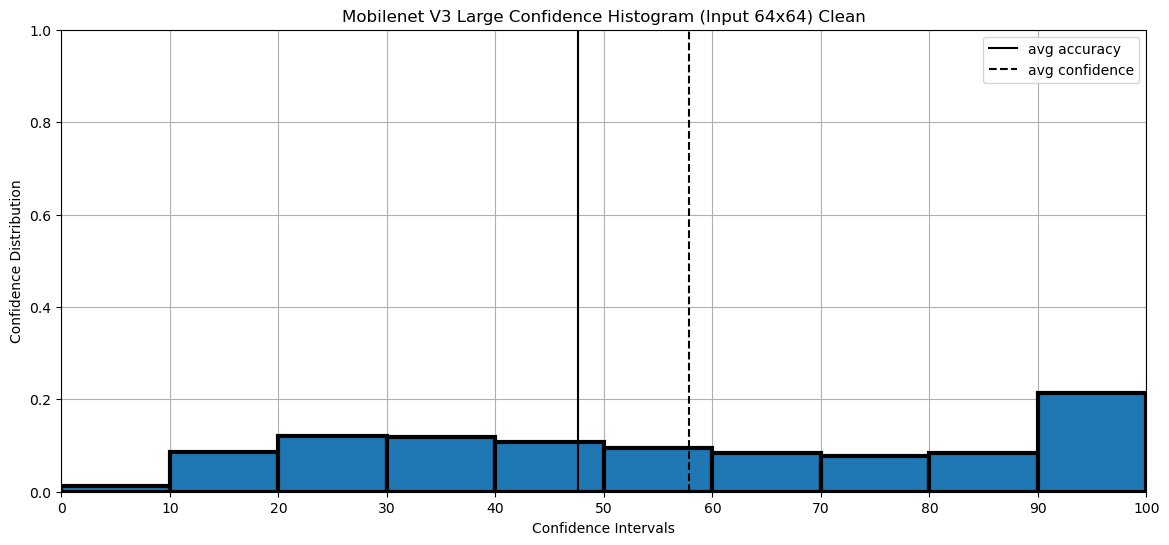

In [119]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = total_acc64*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

reliability plot for 64

[tensor(0.0273), tensor(0.0557), tensor(0.0825), tensor(0.1085), tensor(0.1101), tensor(0.1365), tensor(0.1563), tensor(0.1568), tensor(0.1375), tensor(0.0586)]
[tensor(0.0548), tensor(0.1010), tensor(0.1688), tensor(0.2406), tensor(0.3385), tensor(0.4114), tensor(0.4932), tensor(0.5934), tensor(0.7146), tensor(0.9113)]


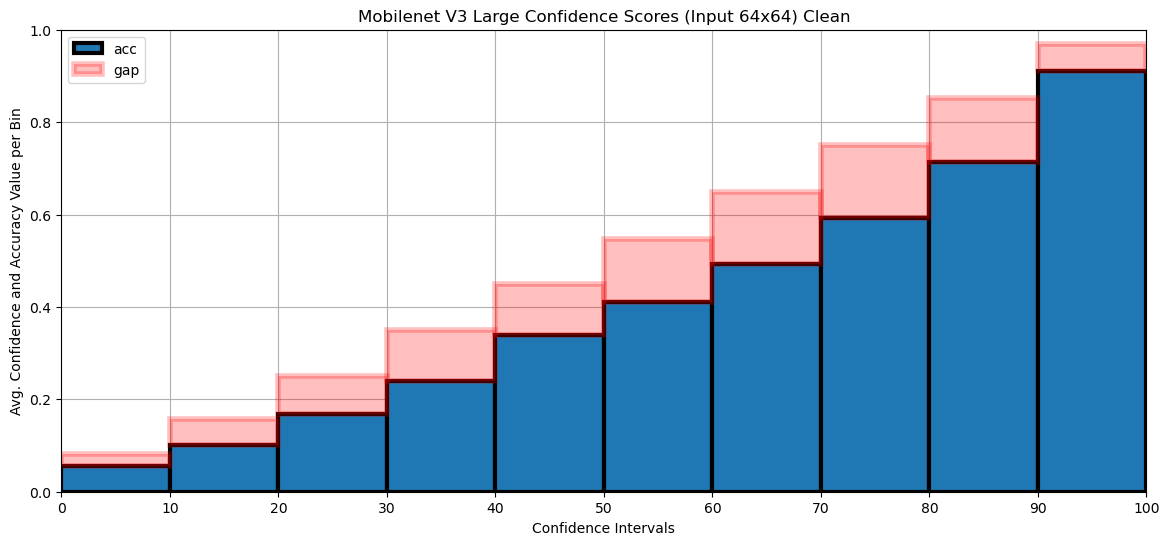

In [121]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(confs64_cal):
    if c > accs64_cal[i]:
        bot.append(accs64_cal[i])
        top.append(c-accs64_cal[i])
    else:
        bot.append(c)
        top.append(accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 64x64) Clean')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [156]:
print("ECE:",sum([abs(accs64_cal[i] - confs64_cal[i])*confs_hist64[i] for i in range(len(confs64_cal))]))

ECE: tensor(0.1022)


## Corrupted Confidence Scores

### function to get scores for all corruptions

In [131]:
# pass in validation sets and model
def get_conf_cal_corr(data_loaders, model):
    # store confidences and prediction results over all validation sets
    confidences = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    accuracies = torch.zeros(len(data_loaders[0].dataset)*len(data_loaders))
    print(len(confidences))

    # iterate over all validation sets
    with torch.no_grad():
        for dl_idx, data_loader in enumerate(data_loaders):
            print(corruptions[dl_idx])
            idx = 0
            for (img_batch, label_batch) in tqdm(data_loader):
                img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

                start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
                end = start + len(label_batch)

                # get the model's softmax output and class predictions, then get a mask of correct predictions
                conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
                acc = pred.eq(label_batch)
                conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

                confidences[start:end] = conf
                accuracies[start:end] = acc

                idx +=  1

    # initialize the calibration bins
    n_bins = 10
    bin_boundaries = torch.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    accs = [0.0]*n_bins
    avg_confs = [0.0]*n_bins
    confs_hist = [0.0]*n_bins
    total_avg_conf = 0.0
    total_acc = 0.0

    i = 0
    # iterate over bins
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # mask to determine which confidence scores go in this bin
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        print(in_bin,"/",len(in_bin))

        # from the mask determine what percent of the confidence scores are in this bin
        prop_in_bin = in_bin.float().mean()

        confs_hist[i] = len(confidences[in_bin])/(len(data_loader.dataset)*len(data_loaders))

        # if the bin is not empty
        if prop_in_bin.item() > 0:
            # calculate accuracy of the bin using the mask of correct predictions
            accuracy_in_bin = accuracies[in_bin].float().mean()

            # get the average confidence score of items in this bin
            avg_confidence_in_bin = confidences[in_bin].mean()
            accs[i] = accuracy_in_bin
            avg_confs[i] = avg_confidence_in_bin.detach()
        i+=1
        
    total_avg_conf = sum([avg_confs[i]*confs_hist[i] for i in range(len(confs_hist))]) # weight by confidence histogram
    total_acc = sum([accs[i]*confs_hist[i] for i in range(len(confs_hist))])
    
    # return the accuracy of all bins and the average confidence score of the bins
    return accs, avg_confs, confs_hist, total_avg_conf, total_acc

In [132]:
corr_accs_cal, corr_confs_cal, corr_confs_hist, corr_total_avg_conf, corr_total_acc  = get_conf_cal_corr(corr_val_loaders,model)
corr_accs64_cal, corr_confs64_cal,corr_confs_hist64, corr_total_avg_conf64, corr_total_acc64  = get_conf_cal_corr(corr_val_loaders64,model64)

750000
gaussian_noise


100%|██████████| 391/391 [00:26<00:00, 14.83it/s]


impulse_noise


100%|██████████| 391/391 [00:26<00:00, 14.89it/s]


shot_noise


100%|██████████| 391/391 [00:26<00:00, 14.98it/s]


defocus_blur


100%|██████████| 391/391 [00:23<00:00, 16.78it/s]


glass_blur


100%|██████████| 391/391 [00:23<00:00, 16.80it/s]


motion_blur


100%|██████████| 391/391 [00:23<00:00, 16.33it/s]


zoom_blur


100%|██████████| 391/391 [00:22<00:00, 17.31it/s]


snow


100%|██████████| 391/391 [00:23<00:00, 16.39it/s]


frost


100%|██████████| 391/391 [00:24<00:00, 15.81it/s]


fog


100%|██████████| 391/391 [00:22<00:00, 17.18it/s]


brightness


100%|██████████| 391/391 [00:23<00:00, 16.73it/s]


contrast


100%|██████████| 391/391 [00:22<00:00, 17.33it/s]


elastic_transform


100%|██████████| 391/391 [00:22<00:00, 17.03it/s]


jpeg_compression


100%|██████████| 391/391 [00:22<00:00, 17.70it/s]


pixelate


100%|██████████| 391/391 [00:23<00:00, 16.75it/s]


tensor([ True, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False,  True]) / 750000
tensor([False, False,  True,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False,  True, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ...,  True, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
750000
gaussian_noise


100%|██████████| 391/391 [00:04<00:00, 81.60it/s]


impulse_noise


100%|██████████| 391/391 [00:04<00:00, 82.23it/s]


shot_noise


100%|██████████| 391/391 [00:04<00:00, 81.31it/s]


defocus_blur


100%|██████████| 391/391 [00:04<00:00, 83.82it/s]


glass_blur


100%|██████████| 391/391 [00:04<00:00, 81.44it/s]


motion_blur


100%|██████████| 391/391 [00:04<00:00, 84.05it/s]


zoom_blur


100%|██████████| 391/391 [00:04<00:00, 83.80it/s]


snow


100%|██████████| 391/391 [00:04<00:00, 82.14it/s]


frost


100%|██████████| 391/391 [00:04<00:00, 82.26it/s]


fog


100%|██████████| 391/391 [00:04<00:00, 83.15it/s]


brightness


100%|██████████| 391/391 [00:04<00:00, 83.32it/s]


contrast


100%|██████████| 391/391 [00:04<00:00, 83.73it/s]


elastic_transform


100%|██████████| 391/391 [00:04<00:00, 82.74it/s]


jpeg_compression


100%|██████████| 391/391 [00:04<00:00, 84.29it/s]


pixelate


100%|██████████| 391/391 [00:04<00:00, 83.18it/s]

tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False,  True, False,  ..., False, False, False]) / 750000
tensor([False, False,  True,  ...,  True, False,  True]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([ True, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000
tensor([False, False, False,  ..., False,  True, False]) / 750000
tensor([False, False, False,  ..., False, False, False]) / 750000


corr hist for 224

(-2.5, 47.5)

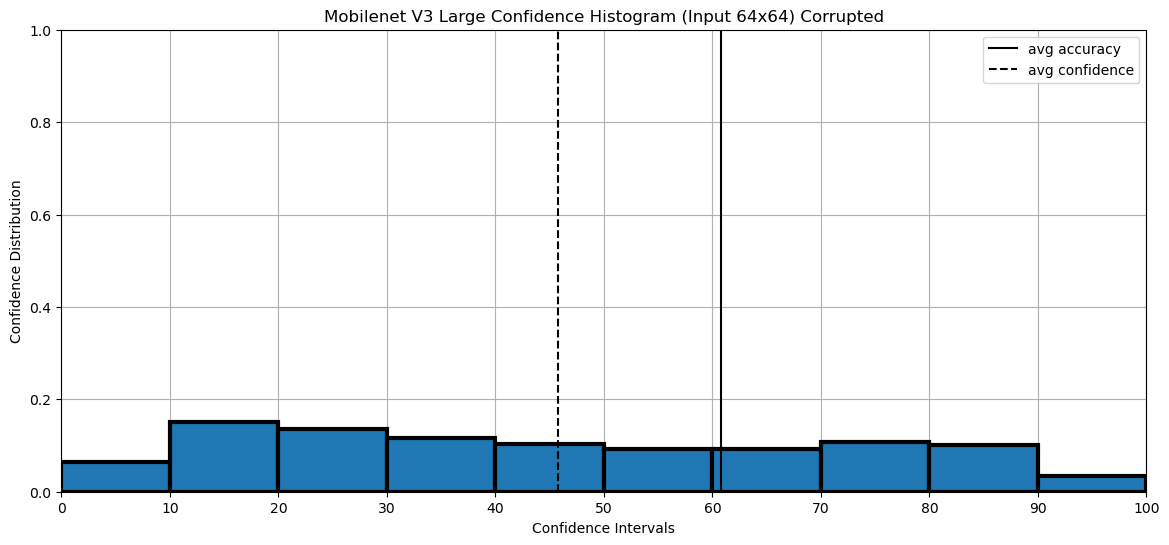

In [133]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 224

[tensor(0.0547), tensor(0.0996), tensor(0.1464), tensor(0.1774), tensor(0.2000), tensor(0.2109), tensor(0.2046), tensor(0.1732), tensor(0.1183), tensor(0.0446)]
[tensor(0.0722), tensor(0.1499), tensor(0.2488), tensor(0.3491), tensor(0.4488), tensor(0.5497), tensor(0.6507), tensor(0.7515), tensor(0.8467), tensor(0.9319)]


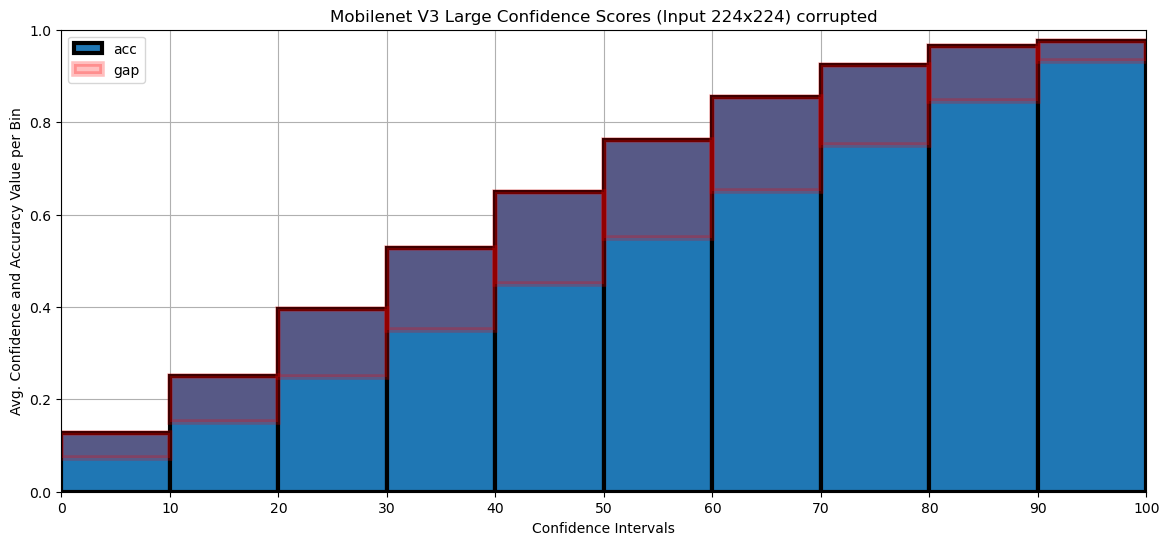

In [136]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs_cal):
    if c > corr_accs_cal[i]:
        bot.append(corr_accs_cal[i])
        top.append(c-corr_accs_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [157]:
print("ECE:",sum([abs(corr_accs_cal[i] - corr_confs_cal[i])*corr_confs_hist[i] for i in range(len(corr_confs_cal))]))

ECE: tensor(0.1505)


corr hist for 64

(-2.5, 47.5)

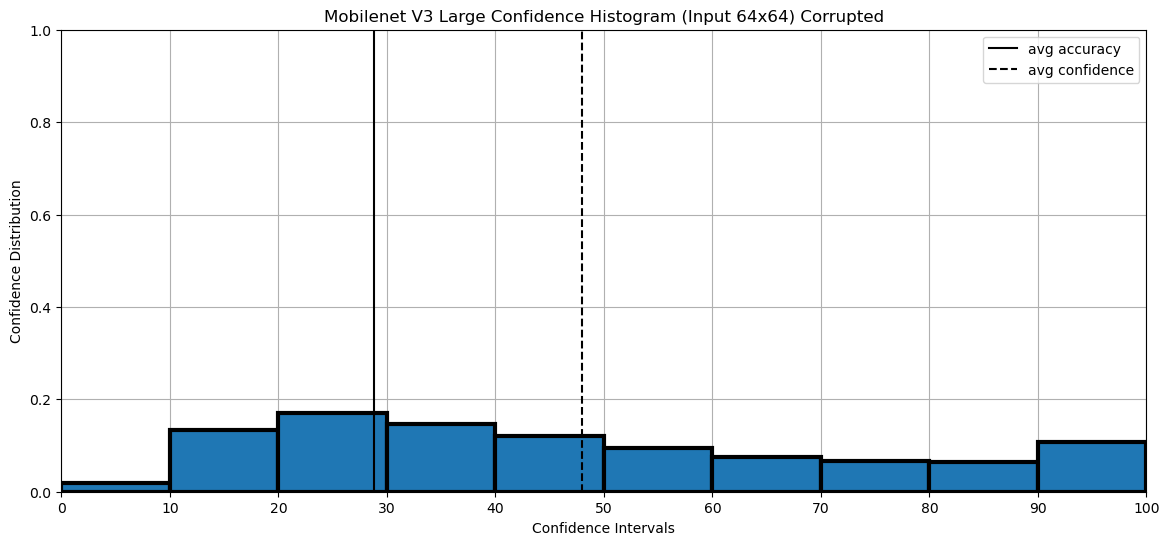

In [139]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.rc('axes', axisbelow=True)
plt.grid()
plt.bar(xpos[:-1],corr_confs_hist64,width=5,edgecolor = "black",linewidth=3)
plt.xticks(xtickpos, bars)
plt.axvline(x = corr_total_acc54*50-2.5, color = 'k', label = 'avg accuracy')
plt.axvline(x = corr_total_avg_conf64*50-2.5, color = 'k', label = 'avg confidence',linestyle="--")
plt.legend()
plt.title('Mobilenet V3 Large Confidence Histogram (Input 64x64) Corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Confidence Distribution")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])

corr reliability for 64

[tensor(0.0448), tensor(0.0865), tensor(0.1365), tensor(0.1841), tensor(0.2254), tensor(0.2608), tensor(0.2953), tensor(0.3096), tensor(0.2904), tensor(0.1407)]
[tensor(0.0373), tensor(0.0695), tensor(0.1131), tensor(0.1643), tensor(0.2229), tensor(0.2869), tensor(0.3533), tensor(0.4393), tensor(0.5598), tensor(0.8228)]


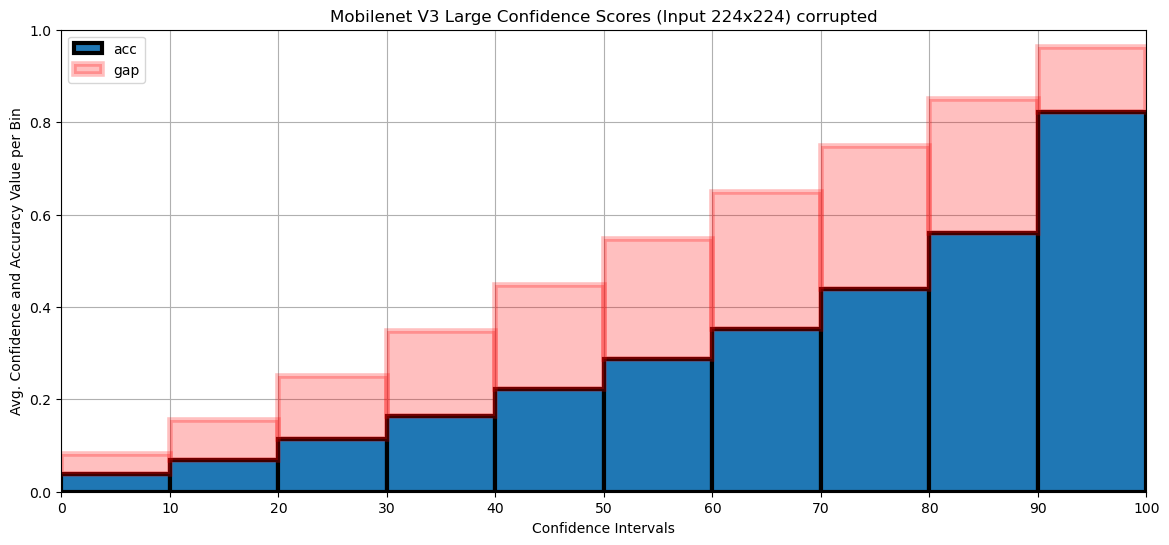

In [146]:
figure(figsize=(14, 6), dpi=100)
bars = ["0","10","20","30","40","50","60","70","80","90","100"]
xpos = [0,5,10,15,20,25,30,35,40,45,50]
xtickpos = [xpos[i]-2.5 for i in range(len(xpos))]
plt.bar(xpos[:-1],corr_accs64_cal,label="acc",width=5,edgecolor='black',linewidth=3)
plt.xticks(xtickpos, bars)
bot = []
top = []
for i,c in enumerate(corr_confs64_cal):
    if c > corr_accs64_cal[i]:
        bot.append(corr_accs64_cal[i])
        top.append(c-corr_accs64_cal[i])
    else:
        bot.append(c)
        top.append(corr_accs64_cal[i]-c)
print(top)
print(bot)
plt.bar(xpos[:-1],top,label="gap",width=5,edgecolor='red',bottom=bot,color='red',alpha=0.25,linewidth=4)
plt.legend()
plt.title('Mobilenet V3 Large Confidence Scores (Input 224x224) corrupted')
plt.xlabel("Confidence Intervals")
plt.ylabel("Avg. Confidence and Accuracy Value per Bin")
plt.ylim([0,1])
plt.xlim([-2.5,47.5])
plt.grid()

In [158]:
print("ECE:",sum([abs(corr_accs64_cal[i] - corr_confs64_cal[i])*corr_confs_hist64[i] for i in range(len(corr_confs64_cal))]))

ECE: tensor(0.1913)


# Online Accuracies

## Deterministic Baselines

get all the confidences and results for each model on each dataset
* pre-computing then reusing results after is faster
* only works for fixed model

In [147]:
# confidence is highest softmax output
# result is whether a prediction was correct

# all confs and results on clean sets
clean_confidences = torch.zeros(len(clean_val_loader.dataset))
clean_results = torch.zeros(len(clean_val_loader.dataset))
clean_confidences64 = torch.zeros(len(clean_val_loader.dataset))
clean_results64 = torch.zeros(len(clean_val_loader.dataset))

# all confs and results on corrupted sets
corr_confidences = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_confidences64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))
corr_results64 = torch.zeros(len(clean_val_loader.dataset)*len(corruptions))

# put all datasets in fixed order
# fixed_order = CustomOrder(clean_val_loader.dataset)
# rand_corr_order = torch.randperm(15)

with torch.no_grad():
    # first get the clean results for 224 and 64
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences[start:end] = conf
        clean_results[start:end] = res
        batch_idx += 1
    batch_idx = 0
    for (img_batch, label_batch) in tqdm(clean_val_loader64):
        img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')
        start = batch_idx*clean_val_loader64.batch_size
        end = start + len(label_batch)

        # get the model's softmax output and class predictions
        conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
        res = pred.eq(label_batch)
        conf,res = conf.to('cpu'),res.to('cpu')

        clean_confidences64[start:end] = conf
        clean_results64[start:end] = res
        batch_idx += 1

    # get corrupted results
    for dl_idx, data_loader in enumerate(corr_val_loaders):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences[start:end] = conf
            corr_results[start:end] = acc

            idx +=  1

    for dl_idx, data_loader in enumerate(corr_val_loaders64):
        print(corruptions[dl_idx])
        idx = 0
        for (img_batch, label_batch) in tqdm(data_loader):
            img_batch, label_batch = img_batch.to('cuda'), label_batch.to('cuda')

            start = dl_idx*len(data_loader.dataset) + idx*data_loader.batch_size
            end = start + len(label_batch)

            # get the model's softmax output and class predictions, then get a mask of correct predictions
            conf, pred = torch.max(F.softmax(model64(img_batch), dim=1), 1)
            acc = pred.eq(label_batch)
            conf,pred,acc = conf.to('cpu'),pred.to('cpu'),acc.to('cpu')

            corr_confidences64[start:end] = conf
            corr_results64[start:end] = acc

            idx +=  1

100%|██████████| 391/391 [00:18<00:00, 20.61it/s]


gaussian_noise


100%|██████████| 391/391 [00:26<00:00, 14.49it/s]


impulse_noise


100%|██████████| 391/391 [00:26<00:00, 14.81it/s]


shot_noise


100%|██████████| 391/391 [00:26<00:00, 14.52it/s]


defocus_blur


100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


glass_blur


100%|██████████| 391/391 [00:24<00:00, 16.23it/s]


motion_blur


100%|██████████| 391/391 [00:24<00:00, 16.22it/s]


zoom_blur


100%|██████████| 391/391 [00:23<00:00, 16.39it/s]


snow


100%|██████████| 391/391 [00:25<00:00, 15.44it/s]


frost


100%|██████████| 391/391 [00:25<00:00, 15.56it/s]


fog


100%|██████████| 391/391 [00:23<00:00, 16.48it/s]


brightness


100%|██████████| 391/391 [00:24<00:00, 16.11it/s]


contrast


100%|██████████| 391/391 [00:23<00:00, 16.49it/s]


elastic_transform


100%|██████████| 391/391 [00:24<00:00, 16.15it/s]


jpeg_compression


100%|██████████| 391/391 [00:23<00:00, 16.68it/s]


pixelate


100%|██████████| 391/391 [00:24<00:00, 16.15it/s]


gaussian_noise


100%|██████████| 391/391 [00:04<00:00, 81.33it/s]


impulse_noise


100%|██████████| 391/391 [00:04<00:00, 80.09it/s]


shot_noise


100%|██████████| 391/391 [00:04<00:00, 79.09it/s]


defocus_blur


100%|██████████| 391/391 [00:04<00:00, 82.48it/s]


glass_blur


100%|██████████| 391/391 [00:04<00:00, 79.50it/s]


motion_blur


100%|██████████| 391/391 [00:04<00:00, 82.56it/s]


zoom_blur


100%|██████████| 391/391 [00:04<00:00, 83.01it/s]


snow


100%|██████████| 391/391 [00:04<00:00, 80.85it/s]


frost


100%|██████████| 391/391 [00:04<00:00, 81.65it/s]


fog


100%|██████████| 391/391 [00:04<00:00, 83.30it/s]


brightness


100%|██████████| 391/391 [00:04<00:00, 81.53it/s]


contrast


100%|██████████| 391/391 [00:04<00:00, 83.34it/s]


elastic_transform


100%|██████████| 391/391 [00:04<00:00, 83.50it/s]


jpeg_compression


100%|██████████| 391/391 [00:04<00:00, 84.65it/s]


pixelate


100%|██████████| 391/391 [00:04<00:00, 82.62it/s]


### setting the ordering

In [148]:
from torch.utils.data import Subset

from torch.utils.data.sampler import Sampler

class CustomOrder(Sampler):
    def __init__(self, dataset):
        self.order = torch.randperm(len(dataset))
        
    def __iter__(self):
        return iter(self.order)
    
    def __len__(self):
        return len(self.order)

rand_order = CustomOrder(clean_val_loader.dataset)
rand_corr_order = torch.randperm(15)

### evaluating strategies for fixed model

In [161]:
# clean baseline
clean_online_acc = []
clean_online_efficiency = []
clean_online_acc64 = []
clean_online_efficiency64 = []
clean_naive_online_acc = []
clean_naive_efficiency = []
clean_oracle_acc = []
clean_oracle_efficiency = []
idxs = []

num_imgs = 0

clean_num_correct = 0
clean_num_correct64 = 0
clean_num_naive_correct = 0
clean_num_oracle_correct = 0


clean_naive_num_wrong_decisions = 0
clean_naive_num_choose_small = 0
clean_naive_num_choose_big = 0
clean_oracle_num_choose_small = 0
clean_oracle_num_choose_big = 0

small_right_big_wrong = []
big_right_small_wrong = []

clean_overconfident_locations = []
clean_overconfident_imgs = []
clean_underconfident_locations = []
clean_underconfident_imgs = []

for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the prediction
    out = clean_confidences[sample_idx]
    out64 = clean_confidences64[sample_idx]
    res = clean_results[sample_idx]
    res64 = clean_results64[sample_idx]
    clean_num_correct += res
    clean_num_correct64 += res64
    clean_online_acc.append(clean_num_correct/num_imgs)
    clean_online_acc64.append(clean_num_correct64/num_imgs)
    clean_online_efficiency.append(0)
    clean_online_efficiency64.append(1)

    # oracle, if small is right choose small, else choose big
    if res64:
        clean_num_oracle_correct += res64
        clean_oracle_num_choose_small += 1
    else:
        clean_num_oracle_correct += res
        clean_oracle_num_choose_big += 1
    clean_oracle_acc.append(clean_num_oracle_correct/num_imgs) 
    clean_oracle_efficiency.append(clean_oracle_num_choose_small/num_imgs)   

    if not res and res64:
        small_right_big_wrong.append(sample_idx)
    if not res64 and res:
        big_right_small_wrong.append(sample_idx)

    # naive strategy, if less than 50% confident, use big model
    if out64.item() < 0.50:
        clean_num_naive_correct += res
        clean_naive_num_choose_big += 1
        # if was underconfident
        if res64:
            clean_naive_num_wrong_decisions += 1
            clean_underconfident_imgs.append(sample_idx)
            clean_underconfident_locations.append(num_imgs)
    else:
        clean_num_naive_correct += res64
        clean_naive_num_choose_small += 1
        # if was overconfident
        if not res64 and res:
            clean_naive_num_wrong_decisions += 1
            clean_overconfident_imgs.append(sample_idx)
            clean_overconfident_locations.append(num_imgs)
    clean_naive_online_acc.append(clean_num_naive_correct/num_imgs)
    clean_naive_efficiency.append(clean_naive_num_choose_small/num_imgs)

    idxs.append(num_imgs)

100%|██████████| 50000/50000 [00:01<00:00, 40334.10it/s]


### accuracy

(0.0, 1.0)

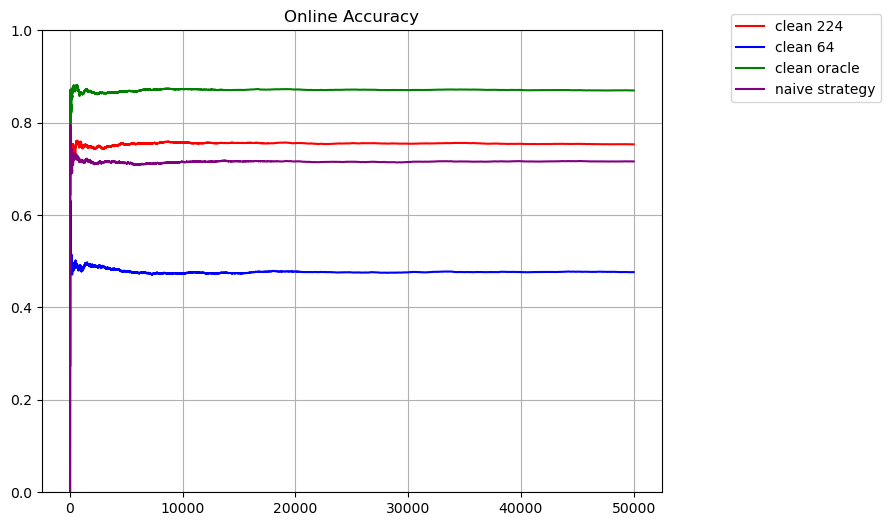

In [165]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_acc,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_online_acc,label='naive strategy',color='purple')

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.title("Online Accuracy")
plt.ylim([0,1])

### efficiency

(-0.1, 1.1)

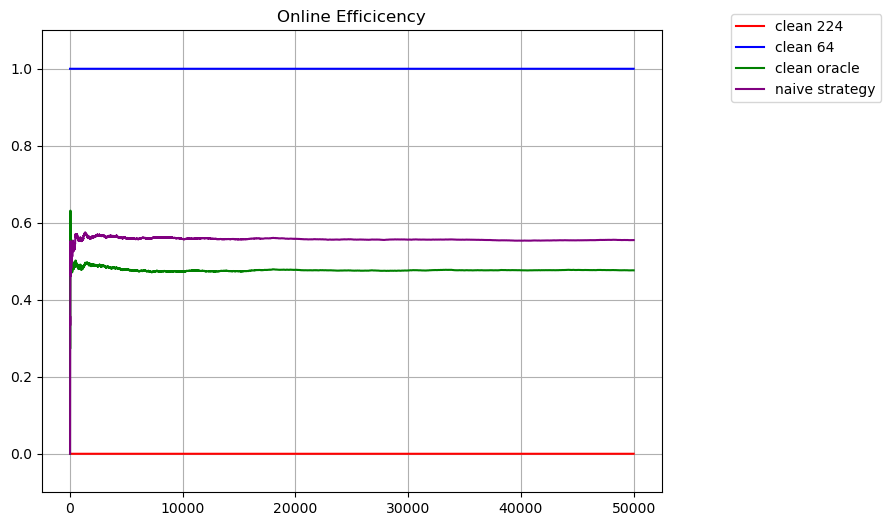

In [170]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_efficiency,label='clean 224',color='red')
ax1.plot(idxs,clean_online_efficiency64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_efficiency,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_efficiency,label='naive strategy',color='purple')
plt.title("Online Efficicency")
# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")
plt.grid()
plt.ylim([-0.1,1.1])

### pareto curve for accuracy and efficiency

In [192]:
efficiencies = [0,0.1]#,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
acc_for_eff = []
big_model_idxs = [torch.zeros(len(clean_results))] 
small_model_idxs = []
for eff in efficiencies:
    curr_acc = 0
    # choose only big
    if eff == 0:
        # acc_for_eff.append(sum(clean_results)/len(clean_results))
        big_model_idxs.append((clean_results >= 0).nonzero())
        small_model_idxs.append((clean_results < 0).nonzero())
        continue
    # choose only small
    if eff == 1:
        # acc_for_eff.append(sum(clean_results64)/len(clean_results64))
        big_model_idxs.append((clean_results64 < 0).nonzero())
        small_model_idxs.append((clean_results64 >= 0).nonzero())
        continue
    
    # for a given efficiency
    eff_thresh = int(eff*len(clean_confidences))
    total_thresh = int(len(clean_confidences))

    # get all idxs where small correct, big wrong
    small_correct_big_wrong_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 0)).nonzero()

    # get all idxs where small and big correct
    small_big_correct_idxs = torch.logical_and((clean_results64 == 1),(clean_results == 1)).nonzero()

    # get all idxs where small wrong, big correct
    small_wrong_big_correct_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 1)).nonzero()

    # get all idxs where big wrong and small wrong
    small_wrong_big_wrong_idxs = torch.logical_and((clean_results64 == 0),(clean_results == 0)).nonzero()
    
    curr_idxs = torch.clone(small_correct_big_wrong_idxs)

    # if above eff threshold
    if len(curr_idxs) > eff_thresh:
        # remove small until reach efficiency
        curr_idxs = curr_idxs[:eff_thresh]
        small_model_idx_tensor = 

        # add big correct, small incorrect
        curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs))
        
        # if above total thresh
        if len(curr_idxs) > total_thresh:
            # remove some big to fit the threshold
            curr_idxs = curr_idxs[:total_thresh]
            continue
        else:
            # add some big wrong and small wrong to fit the threshold
            amnt = total_thresh - len(curr_idxs)
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs[:amnt]))
            continue
    else:
        # get more by adding predictions which both small and big correct
        curr_idxs = torch.cat((curr_idxs,small_big_correct_idxs))

        # if above efficicency threshold
        if len(curr_idxs) > eff_thresh:
            # remove some small/big correct
            curr_idxs = curr_idxs[:eff_thresh]

            # add big correct, small incorrect
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs))
            
            # if above total thresh
            if len(curr_idxs) > total_thresh:
                # remove some big to fit the threshold
                curr_idxs = curr_idxs[:total_thresh]
                continue
            else:
                # add some big wrong and small wrong to fit the threshold
                amnt = total_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs[:amnt]))
                continue
        else:
            # add small wrong big correct
            curr_idxs = torch.cat((curr_idxs,small_wrong_big_correct_idxs))

            # if above eff thresh
            if len(curr_idxs) > eff_thresh:
                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    continue
                else:
                    # add some big wrong and small wrong to fit the threshold
                    amnt = total_thresh - len(curr_idxs)
                    curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs[:amnt]))
                    continue
            else:
                # add small wrong and big wrong to reach eff thresh
                amnt = eff_thresh - len(curr_idxs)
                curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs[:amnt]))
                # if above total thresh
                if len(curr_idxs) > total_thresh:
                    # remove some big to fit the threshold
                    curr_idxs = curr_idxs[:total_thresh]
                    continue
                else:
                    # add some big wrong and small wrong to fit the threshold
                    amnt = total_thresh - len(curr_idxs)
                    curr_idxs = torch.cat((curr_idxs,small_wrong_big_wrong_idxs[:amnt]))
                    continue


In [197]:
(clean_results < 0).nonzero()

tensor([], size=(0, 1), dtype=torch.int64)

clean baseline

In [17]:
# clean baseline
clean_online_acc = []
clean_online_acc64 = []
clean_naive_online_acc = []
clean_oracle_acc = []
idxs = []

num_imgs = 0

clean_num_correct = 0
clean_num_correct64 = 0
clean_num_naive_correct = 0
clean_num_oracle_correct = 0

clean_num_wrong_decisions = 0
clean_num_choose_itself = 0
clean_num_choose_big = 0

clean_overconfident_locations = []
clean_overconfident_imgs = []
clean_underconfident_locations = []
clean_underconfident_imgs = []

for sample_idx in tqdm(rand_order):
    num_imgs += 1
    # get the image at the specified index
    img,target = clean_val_loader.dataset[sample_idx]
    img64,target64 = clean_val_loader64.dataset[sample_idx]
    img,target = img.to('cuda'),torch.tensor(target).to('cuda')
    img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
    # get the prediction
    out = model(img.unsqueeze(0))
    out64 = model64(img64.unsqueeze(0))
    pred = out.argmax(dim=1).item()
    pred64 = out64.argmax(dim=1).item()
    res = (pred == target.item())
    res64 = (pred64 == target64.item())
    clean_num_correct += res
    clean_num_correct64 += res64
    clean_online_acc.append(clean_num_correct/num_imgs)
    clean_online_acc64.append(clean_num_correct64/num_imgs)

    # oracle, if small is right choose small, else choose big
    if res64:
        clean_num_oracle_correct += res64
    else:
        clean_num_oracle_correct += res
    clean_oracle_acc.append(clean_num_oracle_correct/num_imgs)    


    # naive strategy, if less than 50% confident, use big model
    if torch.nn.Softmax()(out64).max().item() < 0.50:
        clean_num_naive_correct += res
        clean_num_choose_big += 1
        # if was underconfident
        if res64:
            clean_num_wrong_decisions += 1
            clean_underconfident_imgs.append(sample_idx)
            clean_underconfident_locations.append(num_imgs)
    else:
        clean_num_naive_correct += res64
        clean_num_choose_itself += 1
        # if was overconfident
        if not res64 and res:
            clean_num_wrong_decisions += 1
            clean_overconfident_imgs.append(sample_idx)
            clean_overconfident_locations.append(num_imgs)
    clean_naive_online_acc.append(clean_num_naive_correct/num_imgs)

    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3835347/1797129348.py:52: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if torch.nn.Softmax()(out64).max().item() < 0.50:
100%|██████████| 50000/50000 [12:56<00:00, 64.40it/s]


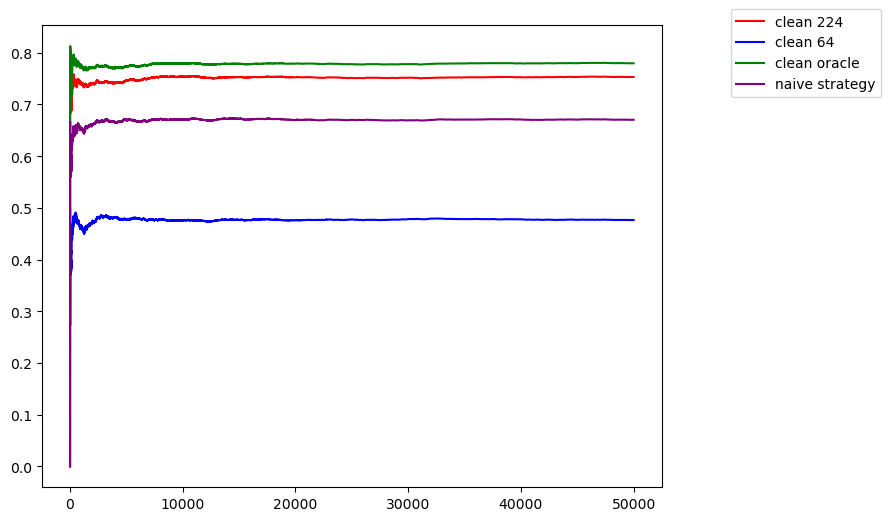

In [19]:
fig1 = plt.figure(figsize=(8,6))
ax1 = fig1.add_subplot(111)
ax1.plot(idxs,clean_online_acc,label='clean 224',color='red')
ax1.plot(idxs,clean_online_acc64,label='clean 64',color='blue')
ax1.plot(idxs,clean_oracle_acc,label='clean oracle',color='green')
# ax1.plot(idxs,corr_online_acc,label='corrupted 224',color='black')
# ax1.plot(idxs,corr_online_acc64,label='corrupted 64',color='green')
ax1.plot(idxs,clean_naive_online_acc,label='naive strategy',color='purple')

# ax2 = ax1.twinx()
# px = overconfident_locations
# py = [naive_online_acc[x] for x in px]
# # plt.scatter(px,py,s=0.5,c='r')
# ax2.hist(px,bins=100,alpha=0.2)
ax1.legend(bbox_to_anchor=(1.1, 1.05))
# ax1.set_ylabel("Online Accuracy")
# ax2.set_ylabel("# overconfident images")
# ax1.set_xlabel("Image Index")

corrupt baseline

In [14]:
# naive strategy
corr_naive_online_acc = []
corr_online_acc = []
corr_online_acc64 = []
idxs = []
num_imgs = 0
corr_num_correct = 0
corr_num_correct64 = 0
corr_num_naive_correct = 0
rand_corr_order = torch.randperm(15)
corr_idx = 0
corr_img_count = 0
corr_num_wrong_decisions = 0
corr_num_choose_itself = 0
corr_num_choose_big = 0
corr_overconfident_locations = []
corr_overconfident_imgs = []
corr_underconfident_locations = []
corr_underconfident_imgs = []
transition_points = [500]
for sample_idx in tqdm(rand_order):
    # corruptions start after the first 500 images
    if num_imgs-1 > 499:
        # each corruption lasts 3300 images
        if corr_img_count == 3300:
            corr_idx += 1
            corr_img_count = 0
            transition_points.append(num_imgs)
        # get the image at the specified index
        img,target = corrs[rand_corr_order[corr_idx]].dataset[sample_idx]
        img64,target64 = corrs64[rand_corr_order[corr_idx]].dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')
        corr_img_count += 1
    else:
        img,target = clean_val_loader.dataset[sample_idx]
        img64,target64 = clean_val_loader64.dataset[sample_idx]
        img,target = img.to('cuda'),torch.tensor(target).to('cuda')
        img64,target64 = img64.to('cuda'),torch.tensor(target64).to('cuda')

    num_imgs += 1
    
    # get the prediction
    out = model(img.unsqueeze(0))
    out64 = model64(img64.unsqueeze(0))
    pred = out.argmax(dim=1).item()
    pred64 = out64.argmax(dim=1).item()
    res = (pred == target.item())
    res64 = (pred64 == target64.item())
    corr_num_correct += res
    corr_num_correct64 += res64
    corr_online_acc.append(corr_num_correct/num_imgs)
    corr_online_acc64.append(corr_num_correct64/num_imgs)

    # naive strategy, if less than 50% confident, use big model
    if torch.nn.Softmax()(out64).max().item() < 0.50:
        corr_num_naive_correct += res
        corr_num_choose_big += 1
        # if was underconfident
        if res64:
            corr_num_wrong_decisions += 1
            corr_underconfident_imgs.append(sample_idx)
            corr_underconfident_locations.append(num_imgs)
    else:
        corr_num_naive_correct += res64
        corr_num_choose_itself += 1
        # if was overconfident
        if not res64 and res:
            corr_num_wrong_decisions += 1
            corr_overconfident_imgs.append(sample_idx)
            corr_overconfident_locations.append(num_imgs)
    corr_naive_online_acc.append(corr_num_naive_correct/num_imgs)
    idxs.append(num_imgs)

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_3835347/1528852718.py:56: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if torch.nn.Softmax()(out64).max().item() < 0.50:
100%|██████████| 50000/50000 [10:17<00:00, 80.91it/s]
